In [124]:
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import unbind_samples
from torchgeo.datasets import RasterDataset

from torchgeo.samplers import RandomGeoSampler

In [331]:
with rio.open('../data/unprocessed_data/label/R2F01SEP2024069380009900053SSANSTUC00GTDC.tif') as src:
    label = src.read().transpose(1,2,0)
    label_profile = src.profile

with rio.open('../data/unprocessed_data/img/R2F01SEP2024069380009900053SSANSTUC00GTDC.tif') as src:
    img = src.read().transpose(1,2,0)
    profile = src.profile

In [ ]:
from torchgeo.samplers import RandomGeoSampler

class NoDataAwareRandomSampler(RandomGeoSampler):
    def __init__(self, dataset, size, length, nodata_value=4294967295.0, max_nodata_ratio=0.1, **kwargs):
        super().__init__(dataset, size, length, **kwargs)
        self.nodata_value = nodata_value
        self.max_nodata_ratio = max_nodata_ratio
        self.dataset = dataset
    
    def __iter__(self):
        generated = 0
        while generated < self.length:
            # Get a random query from parent sampler
            query = next(super().__iter__())
            
            try:
                # Check the sample for nodata
                sample = self.dataset[query]
                if 'mask' in sample:
                    mask = sample['mask']
                    nodata_ratio = (mask == self.nodata_value).float().mean().item()


                    
                    # Skip if too much nodata
                    if nodata_ratio > self.max_nodata_ratio:
                        continue
                
                yield query
                generated += 1
            except Exception as e:
                # Skip problematic samples
                print(f"Skipping sample {query} due to error: {e}")
                continue

In [130]:
class Liss4(RasterDataset):
    filename_glob = '*.tif'
    filename_regex = r'^.{3}(?P<date>\d{2}[A-Z]{3}\d{4})'
    date_format = '%d%b%Y'
    single_band = False
    is_image = True
    seprate_files = False

    def plot(self, sample):
        plt.imshow(sample['image'].permute(1, 2, 0).numpy())

class Liss4_GT(RasterDataset):
    filename_glob = '*.tif'
    filename_regex = r'^.{3}(?P<date>\d{2}[A-Z]{3}\d{4})'
    date_format = '%d%b%Y'
    single_band = False
    is_image = False
    separate_files = False

In [129]:
# sampler = RandomGeoSampler(intersection, size=256, length=32)
sampler = NoDataAwareRandomSampler(
    intersection, 
    size=256, 
    length=10,
    nodata_value=4294967295.0,
    max_nodata_ratio=0.01  # Allow up to 1% nodata
)

NameError: name 'NoDataAwareRandomSampler' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15174253..1.3562173].


[0 1 2]


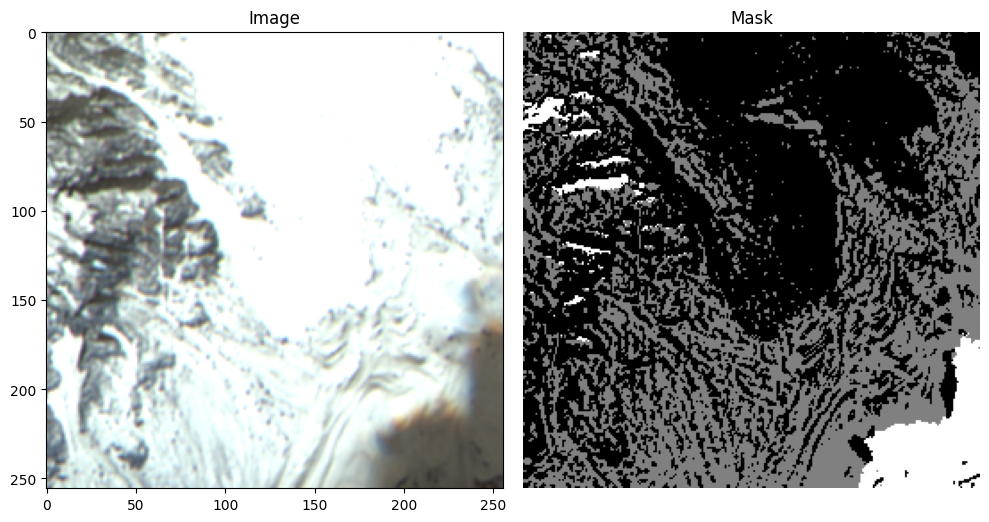

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1625813..1.6310384].


[0 1 2]


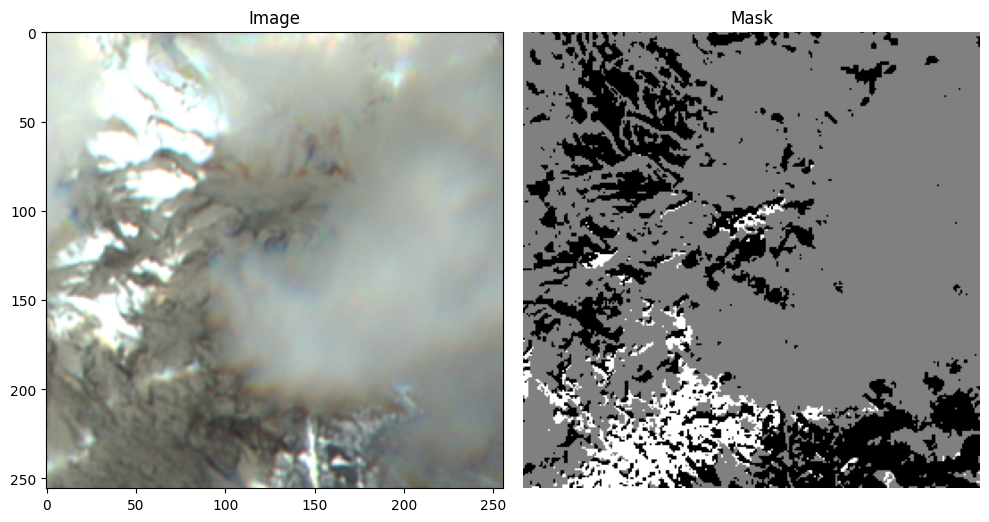

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08206484..1.281414].


[0 1 2]


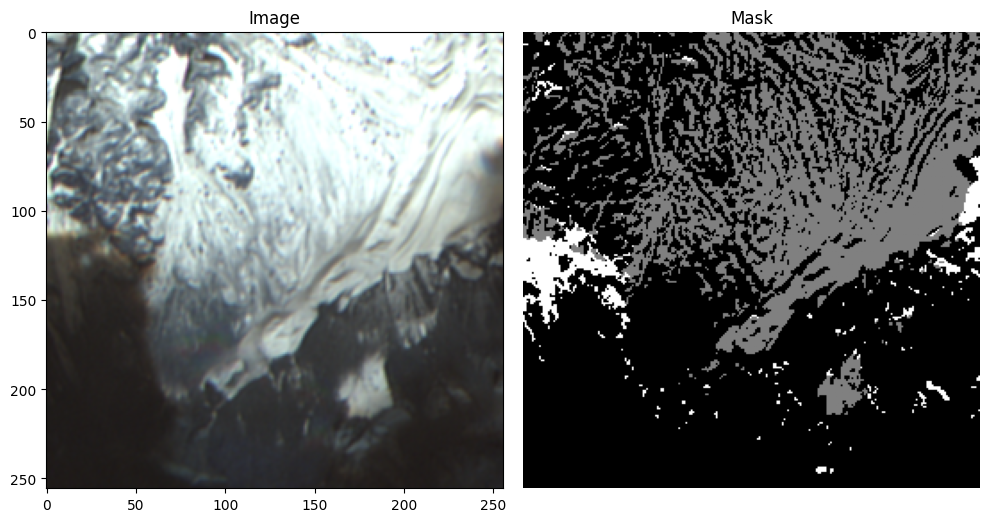

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.080516435..1.1919752].


[0 1 2]


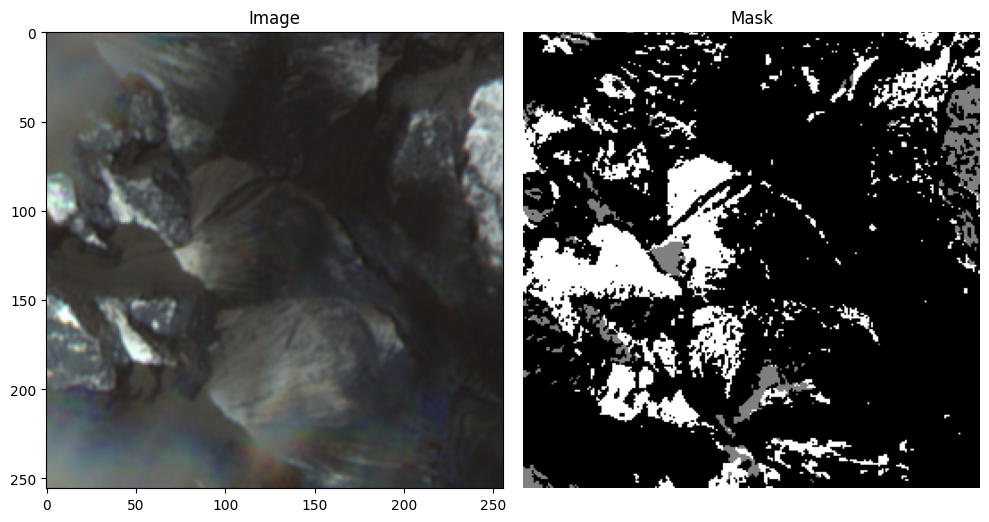

In [ ]:
# sampler = RandomGeoSampler(intersection, size=256, length=32)
# sampler = NoDataAwareRandomSampler(
#     val_dataset, 
#     size=256, 
#     length=100,
#     nodata_value=4294967295.0,
#     max_nodata_ratio=0.01  # Allow up to 1% nodata
# )




val_dataloader = DataLoader(val_dataset, sampler=sampler, batch_size = 32,collate_fn=collate_fn, num_workers=0)

def visulize(dataloader):
    for batch in dataloader:
        sample = unbind_samples(batch)[0]
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(sample['image'].permute(1, 2, 0).numpy())
        ax[0].set_title('Image')
        print(np.unique(sample['mask']))
        ax[1].imshow(sample['mask'].squeeze().numpy(), cmap='gray')
        ax[1].set_title('Mask')
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
train_img = Liss4("../data/unprocessed_data/train/img")
train_label = Liss4_GT("../data/unprocessed_data/train/label")

val_img = Liss4("../data/unprocessed_data/test/img")
val_label = Liss4_GT("../data/unprocessed_data/test/label")


train_dataset = train_img & train_label
val_dataset = val_img & val_label

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)

class UNetDecoder(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.dec1 = DecoderBlock(in_ch, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

        self.out = nn.Conv2d(64, num_classes, 3, padding=1)

    def forward(self, x):
        x = self.dec1(x)  # e.g. 16x16 → 32x32
        x = self.dec2(x)  # 32x32 → 64x64
        x = F.interpolate(x, size=(56,56), mode='bilinear', align_corners=False)
        x = self.dec3(x)  # 56x56 → 112x112
        x = self.dec4(x)  # 112x112 → 224x224
        return self.out(x)

In [119]:
from torchgeo.models import panopticon_vitb14, Panopticon_Weights

class PanopticonUNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=3):
        super().__init__()
        encoder = panopticon_vitb14(weights=Panopticon_Weights.VIT_BASE14, img_size=224)
        for param in encoder.parameters():
                param.requires_grad = False
        self.encoder = encoder.model

        self.decoder = UNetDecoder(in_ch, num_classes)
    
    def forward(self, x):

        x = self.encoder.forward_features(x)
        # B, 257, 768 -> B, 768, 16, 16
        x = x[:, 1:,:].permute(0, 2, 1).reshape(x.shape[0], -1, 16, 16)
        x = self.decoder(x)
        return x
    
model = PanopticonUNet(in_ch=768, num_classes=3)
model = torch.compile(model, fullgraph=True)

In [114]:
parameters = dict(
    lr = 1e-4,
    weight_decay = 1e-4,
    epochs = 10,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=parameters['lr'], weight_decay=parameters['weight_decay'])
criterion = nn.CrossEntropyLoss()   

In [118]:
import time
for epoch in range(parameters['epochs']):
    st = time.time()
    model.train()
    for batch in train_dataloader:
        masks = batch['mask'].squeeze()
        
        optimizer.zero_grad()
        outputs = model(batch)
        
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()

    # validation
    with torch.no_grad():
        model.eval()
        for batch in val_dataloader:
            masks = batch['mask'].squeeze()
            outputs = model(batch)
            loss = criterion(outputs, masks.long())
    ed = time.time()
    print(f"Epoch [{epoch+1}/{parameters['epochs']}], Loss: {loss.item():.4f}, Time: {ed-st:.2f}s")

KeyboardInterrupt: 

In [93]:
with torch.no_grad():
    model.eval()

    outputs = []
    
    for batch in train_dataloader:
        # Get the output from the last layer (before the head)
        output = model(batch)
        print(output.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])


KeyboardInterrupt: 

In [ ]:
for batch in train_dataloader:
    # Get the output from the last layer (before the head)
    output = model(batch)
    print(output.shape)

In [ ]:
from mlflow import MlflowClient

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1750712268646, experiment_id='0', last_update_time=1750712268646, lifecycle_stage='active', name='Default', tags={}>]


In [506]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1750712268646, experiment_id='0', last_update_time=1750712268646, lifecycle_stage='active', name='Default', tags={}>]


In [508]:
default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]
default_experiment
# pprint(default_experiment)

{'name': 'Default', 'lifecycle_stage': 'active'}

In [509]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "In this Experiment, we will check a simple MLP decoder, with a simple MLP neck"
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "cloudSnip",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="Simple_MLP_Decoder", tags=experiment_tags
)

In [510]:
# Use search_experiments() to search on the project_name tag key

apples_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'cloudSnip'"
)

print(vars(apples_experiment[0]))

{'_experiment_id': '441108045867709264', '_name': 'Simple_MLP_Decoder', '_artifact_location': 'mlflow-artifacts:/441108045867709264', '_lifecycle_stage': 'active', '_tags': {'project_name': 'cloudSnip', 'mlflow.note.content': 'In this Experiment, we will check a simple MLP decoder, with a simple MLP neck'}, '_creation_time': 1750745064352, '_last_update_time': 1750745064352}


In [511]:
import mlflow

mlflow.set_tracking_uri("http://localhost:8080")

In [ ]:
mlflow.set_experiment("Simple_MLP_Decoder")
run_name = "MLP_Decoder_v1"
artifact_path = "simple_mlp_decoder"

In [515]:
list(model.modules())
model.ls1

AttributeError: 'Panopticon' object has no attribute 'ls1'

In [ ]:
torch.hub.set_dir("../model")

In [56]:
# load model

model = torch.hub.load('Panopticon-FM/panopticon','panopticon_vitb14')

Using cache found in ../model/Panopticon-FM_panopticon_main
 66%|██████▌   | 250M/378M [00:51<00:26, 5.05MB/s] 


KeyboardInterrupt: 